In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np 
from matplotlib import pyplot as plt 
import networkx as nx 
import pandas as pd 

In [2]:
from dotenv import load_dotenv
import os, sys

load_dotenv()

# Load PROJECT_ROOT
PROJECT_ROOT = os.getenv("PROJECT_ROOT")

# Add PROJECT_ROOT to sys.path
sys.path.append(PROJECT_ROOT)

In [ ]:
routes_df = pd.read_csv(os.path.join(PROJECT_ROOT, "data", "routes_data", "cs_2023-04-01.routes.csv"))
# Only keep the real_waypoints and flight_id columns
routes_df = routes_df[["flight_id", "real_waypoints"]]
routes_df.head()

,flight_id,real_waypoints
0,000042HMJ225,INKIM LJLJ LMML MALTI
1,010092MSR741,LAKTO BIRES_29 EMEDA LCLK
2,010092MSR742,LCA SOBOS_91 LAKTO SISIM
3,010092MSR831,TANSA_98 METRU METRU_30 TOTTI LOTIN REXUN
4,010092MSR832,ODGAX LUMED SALUN_66 METRU_30


In [5]:
# Load the waypoints graph (nodes only)
ats_fra_graph = nx.read_gml(os.path.join(PROJECT_ROOT, "data", "graphs", "ats_fra_nodes_only.gml"))
print(f"ATS-FRA graph has {ats_fra_graph.number_of_nodes()} nodes and {ats_fra_graph.number_of_edges()} edges")

ATS-FRA graph has 33763 nodes and 0 edges


In [7]:
from utils.haversine import haversine_distance

# Function to extract first and last waypoints from the route
def get_first_last_waypoints(waypoints_str):
    waypoints = waypoints_str.split()
    if len(waypoints) < 2:
        return None, None
    return waypoints[0], waypoints[-1]

# Calculate the great circle distance for each route
def calculate_gc_distance(row):
    first_wp, last_wp = get_first_last_waypoints(row['real_waypoints'])
    
    if first_wp is None or last_wp is None:
        return np.nan
    
    try:
        # Get coordinates from the graph
        first_node = ats_fra_graph.nodes[first_wp]
        last_node = ats_fra_graph.nodes[last_wp]
        
        # Calculate distance
        distance = haversine_distance(
            first_node['lat'], first_node['lon'],
            last_node['lat'], last_node['lon']
        )
        return distance
    except KeyError:
        # Handle case where waypoint is not in the graph
        return np.nan

# Add the route_gc_length column to the dataframe
routes_df['route_gc_length'] = routes_df.apply(calculate_gc_distance, axis=1)

# Display the first few rows with the new column
routes_df.head()


,flight_id,real_waypoints,route_gc_length
0,000042HMJ225,INKIM LJLJ LMML MALTI,439.718803
1,010092MSR741,LAKTO BIRES_29 EMEDA LCLK,155.366418
2,010092MSR742,LCA SOBOS_91 LAKTO SISIM,180.431463
3,010092MSR831,TANSA_98 METRU METRU_30 TOTTI LOTIN REXUN,610.653254
4,010092MSR832,ODGAX LUMED SALUN_66 METRU_30,559.241133


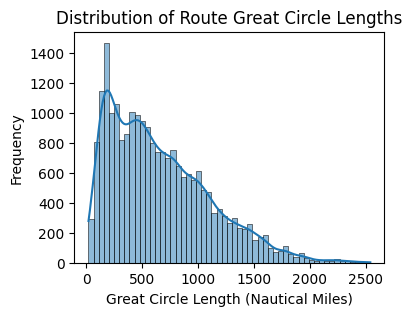

In [10]:
# Create a histogram of route great circle lengths using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
sns.histplot(data=routes_df, x='route_gc_length', kde=True)
plt.title('Distribution of Route Great Circle Lengths')
plt.xlabel('Great Circle Length (Nautical Miles)')
plt.ylabel('Frequency')
plt.show()
